<a href="https://colab.research.google.com/github/hakmin1015/PowerSystemEconomics/blob/main/etc/Practice/climate_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Practice 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/LoadForecasting/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/LoadForecasting


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    label = []

    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size

    for i in range(start_idx, end_idx):
        indices = range(i - history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        label.append(dataset[i + target_size])
    return np.array(data), np.array(label)

In [ ]:
## train data 30만개
train_split = 300000
tf.random.set_seed(13)


In [ ]:
uni_data = df['Tdew (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.90
01.01.2009 00:20:00   -9.28
01.01.2009 00:30:00   -9.31
01.01.2009 00:40:00   -9.07
01.01.2009 00:50:00   -9.04
Name: Tdew (degC), dtype: float64

array([<Axes: xlabel='Date Time'>], dtype=object)

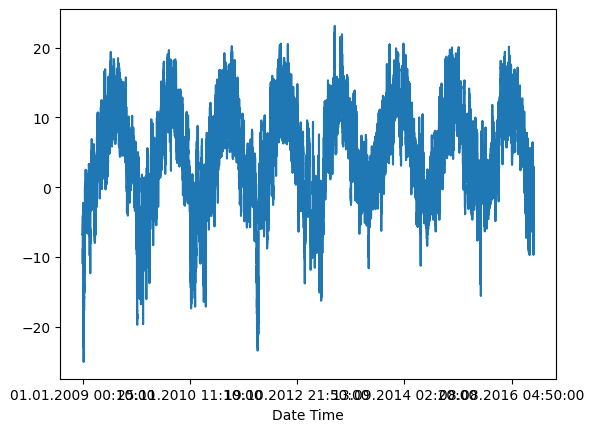

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values

In [ ]:
uni_train_mean = uni_data[:train_split].mean()
uni_train_std = uni_data[:train_split].std()

uni_data = (uni_data - uni_train_mean) / uni_train_std

In [ ]:
x_train_uni, y_train_uni = univariate_data(uni_data, 0, train_split, 20, 0)
x_val_uni, y_val_uni = univariate_data(uni_data, train_split, None, 20, 0)

print(x_train_uni[0])
print(y_train_uni[0])

[[-1.95200996]
 [-2.00644103]
 [-2.01073822]
 [-1.9763607 ]
 [-1.97206352]
 [-1.93482121]
 [-1.86606618]
 [-1.87466056]
 [-1.92765922]
 [-2.01503541]
 [-2.0608721 ]
 [-2.07662846]
 [-2.06660168]
 [-2.06373689]
 [-2.03222417]
 [-2.03795375]
 [-2.04511573]
 [-2.0608721 ]
 [-2.06516929]
 [-2.08379044]]
-2.0809256463665595


In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i , x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    #plt.xticks(color='w')
    #plt.yticks(color='w')
    plt.xlim([time_steps[0], (future+5) * 2])
    plt.xlabel('Time Steps')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

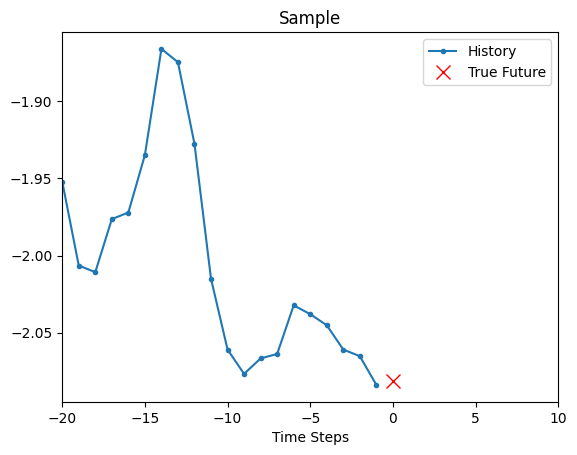

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

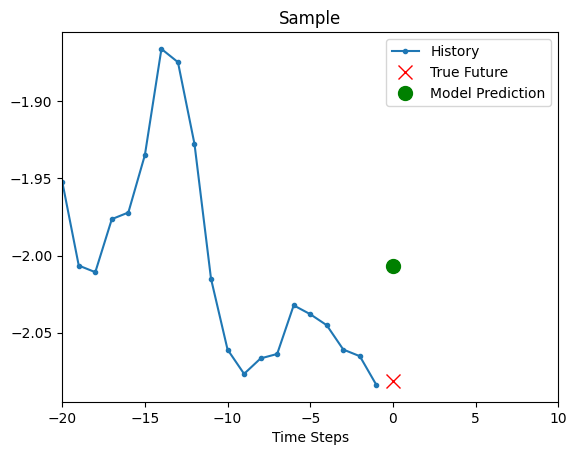

In [ ]:
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Sample')

## LSTM

In [ ]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(256).batch(10000).repeat()

var_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
var_univariate = var_univariate.batch(256).repeat()

In [ ]:
print(x_train_uni.shape)
print(y_train_uni.shape)

(299980, 20, 1)
(299980,)


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape = x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mae')

In [ ]:
for x, y in var_univariate.take(1):
    print(model.predict(x).shape)

8/8 [==============================] - 1s 3ms/step
(256, 1)


In [ ]:
model.fit(train_univariate, epochs = 10, steps_per_epoch=200, validation_data=var_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 33s 154ms/step - loss: 0.2741 - val_loss: 0.0712
Epoch 2/10
200/200 [==============================] - 27s 137ms/step - loss: 0.0914 - val_loss: 0.0397
Epoch 3/10
200/200 [==============================] - 29s 143ms/step - loss: 0.0565 - val_loss: 0.0321
Epoch 4/10
200/200 [==============================] - 26s 130ms/step - loss: 0.0444 - val_loss: 0.0283
Epoch 5/10
200/200 [==============================] - 27s 134ms/step - loss: 0.0373 - val_loss: 0.0248
Epoch 6/10
200/200 [==============================] - 27s 138ms/step - loss: 0.0341 - val_loss: 0.0230
Epoch 7/10
200/200 [==============================] - 27s 137ms/step - loss: 0.0314 - val_loss: 0.0220
Epoch 8/10
200/200 [==============================] - 26s 129ms/step - loss: 0.0291 - val_loss: 0.0216
Epoch 9/10
200/200 [==============================] - 27s 134ms/step - loss: 0.0278 - val_loss: 0.0203
Epoch 10/10
200/200 [==============================] - 27s 137ms/step - l

8/8 [==============================] - 0s 3ms/step


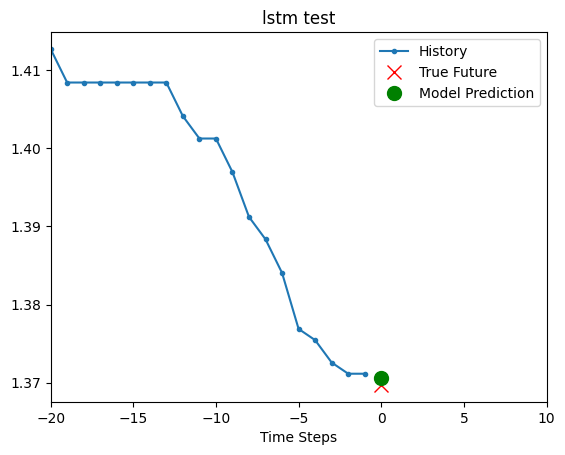

8/8 [==============================] - 0s 4ms/step


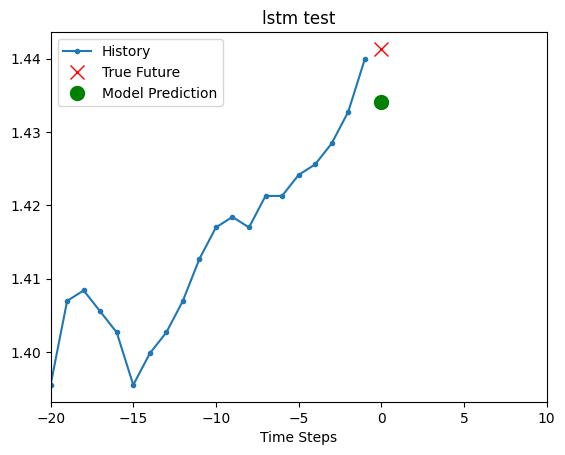

8/8 [==============================] - 0s 4ms/step


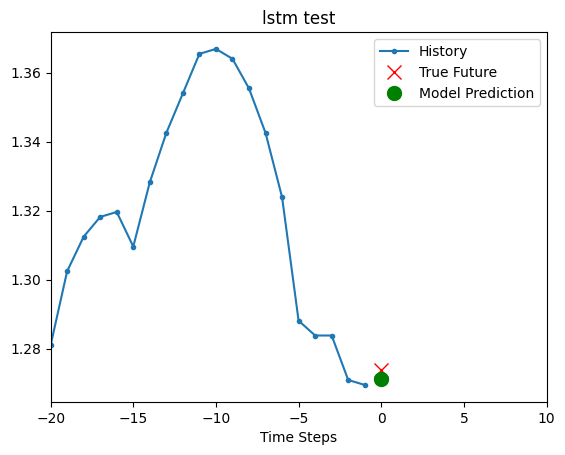

In [ ]:
for x, y in var_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), model.predict(x)[0]], 0, 'lstm test')
    plot.show()

In [ ]:
feature_con = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
feature = df[feature_con]
feature.index = df['Date Time']
feature.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

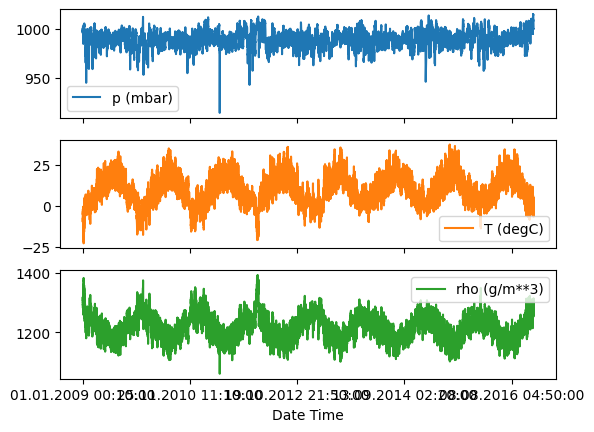

In [ ]:
feature.plot(subplots=True)

In [ ]:
dataset = feature.values
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)

dataset = (dataset-data_mean) / data_std

In [ ]:
def multivariate_data(dataset, target, start_idx, end_idx, history_size, target_size, step, single_step=False):
    data = []
    label = []

    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size

    for i in range(start_idx, end_idx):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            label.append(target[i+target_size])
        else:
            label.append(target[i:i+target_size])

    return np.array(data), np.array(label)

In [ ]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:,1], 0, train_split, 720, 72, 6, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,1], train_split, None, 720, 72, 6, single_step=True)

In [ ]:
print(x_train_single[0].shape)

(120, 3)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(10000).batch(256).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(256).repeat()

In [ ]:
single_model = tf.keras.models.Sequential()
single_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_model.add(tf.keras.layers.Dense(1))

single_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')

In [ ]:
single_history = single_model.fit(train_data_single, epochs=10, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 28s 132ms/step - loss: 0.1727 - val_loss: 0.1036
Epoch 2/10
200/200 [==============================] - 20s 100ms/step - loss: 0.1109 - val_loss: 0.0932
Epoch 3/10
200/200 [==============================] - 21s 104ms/step - loss: 0.1085 - val_loss: 0.0969
Epoch 4/10
200/200 [==============================] - 21s 105ms/step - loss: 0.1042 - val_loss: 0.0861
Epoch 5/10
200/200 [==============================] - 20s 100ms/step - loss: 0.0840 - val_loss: 0.0853
Epoch 6/10
200/200 [==============================] - 21s 105ms/step - loss: 0.0930 - val_loss: 0.1063
Epoch 7/10
200/200 [==============================] - 21s 103ms/step - loss: 0.0966 - val_loss: 0.0992
Epoch 8/10
200/200 [==============================] - 20s 99ms/step - loss: 0.0983 - val_loss: 0.0982
Epoch 9/10
200/200 [==============================] - 21s 105ms/step - loss: 0.0948 - val_loss: 0.0980
Epoch 10/10
200/200 [==============================] - 20s 100ms/step - lo

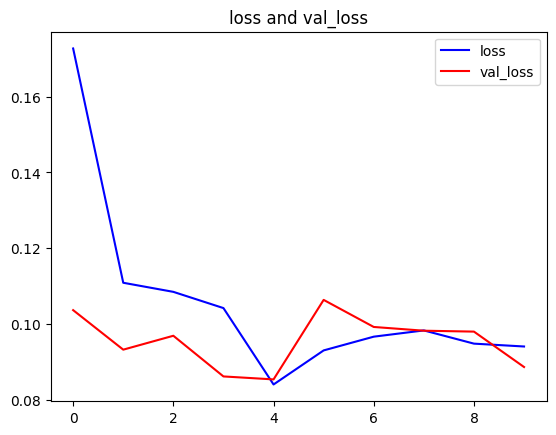

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, 'b', label = 'loss')
    plt.plot(epochs, val_loss, 'r', label='val_loss')
    plt.title(title)
    plt.legend()
    #plt.xticks(color='w')
    #plt.yticks(color='w')
    plt.show()

plot_train_history(single_history, 'loss and val_loss')


In [ ]:
for x, y in val_data_single.take(3):
    print([x[0][:,1].numpy(), y[0].numpy(), single_model.predict(x)[0]])

8/8 [==============================] - 1s 13ms/step
[array([0.642228  , 0.63643877, 0.62138676, 0.60054552, 0.59822982,
       0.57159934, 0.57623073, 0.60286121, 0.62254461, 0.68622619,
       0.71748805, 0.7383293 , 0.77769609, 0.76380193, 0.76843332,
       0.7383293 , 0.71517236, 0.71517236, 0.6989625 , 0.69317327,
       0.68622619, 0.6989625 , 0.70706743, 0.69664681, 0.66075355,
       0.64917509, 0.61212398, 0.60633475, 0.59128274, 0.57159934,
       0.58433566, 0.62138676, 0.65380647, 0.65612217, 0.73254006,
       0.78001179, 0.76843332, 0.68738403, 0.6989625 , 0.71401451,
       0.70822528, 0.71401451, 0.64685939, 0.65264863, 0.64801724,
       0.65264863, 0.65728001, 0.66770064, 0.67580556, 0.67580556,
       0.68506834, 0.68275265, 0.68391049, 0.70590958, 0.76148624,
       0.80085303, 0.82632566, 0.94558389, 1.10768246, 1.21652007,
       1.2790438 , 1.36125093, 1.31030567, 1.28251734, 1.1482071 ,
       1.04747442, 0.99537131, 0.94905743, 0.80432657, 0.74064499,
       0.

8/8 [==============================] - 0s 12ms/step


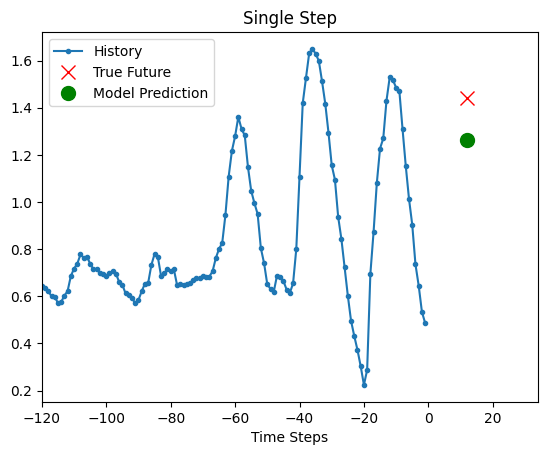

8/8 [==============================] - 0s 12ms/step


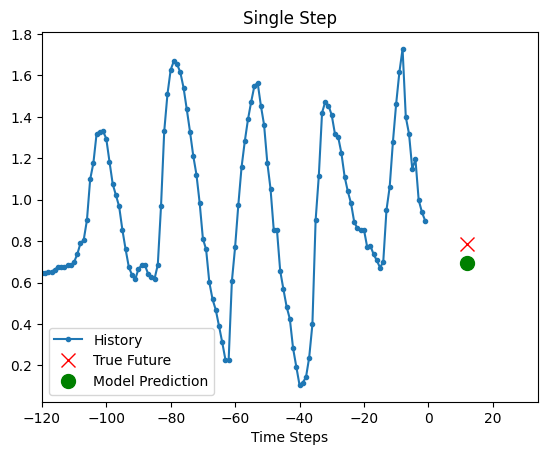

8/8 [==============================] - 0s 12ms/step


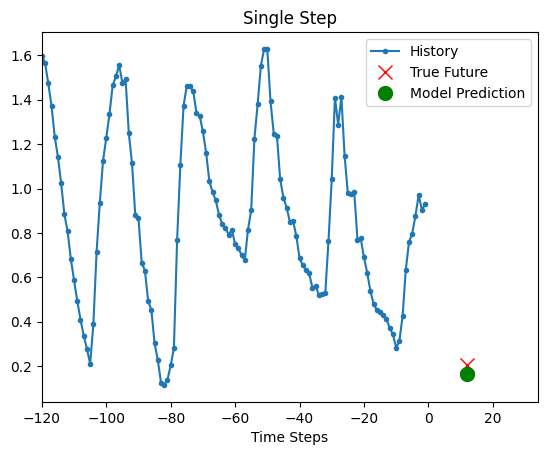

In [ ]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:,1].numpy(), y[0].numpy(), single_model.predict(x)[0]], 12, 'Single Step')
    plot.show()

In [ ]:
#12시간 온도예측
#10분에 1관측 -> 72개의 온도예측

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0, train_split, 720, 72, 6)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1], train_split, None, 720, 72, 6)

print(x_train_multi[0].shape, y_train_multi[0].shape)

(120, 3) (72,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(10000).batch(256).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(256).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12,6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label = 'History')
    plt.plot(np.arange(num_out)/6, np.array(true_future), 'bo', label = 'True Future')

    if prediction.any():
        plt.plot(np.arange(num_out)/6, np.array(prediction), 'ro', label = 'Prediction')

    plt.legend(loc='upper left')
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.show()

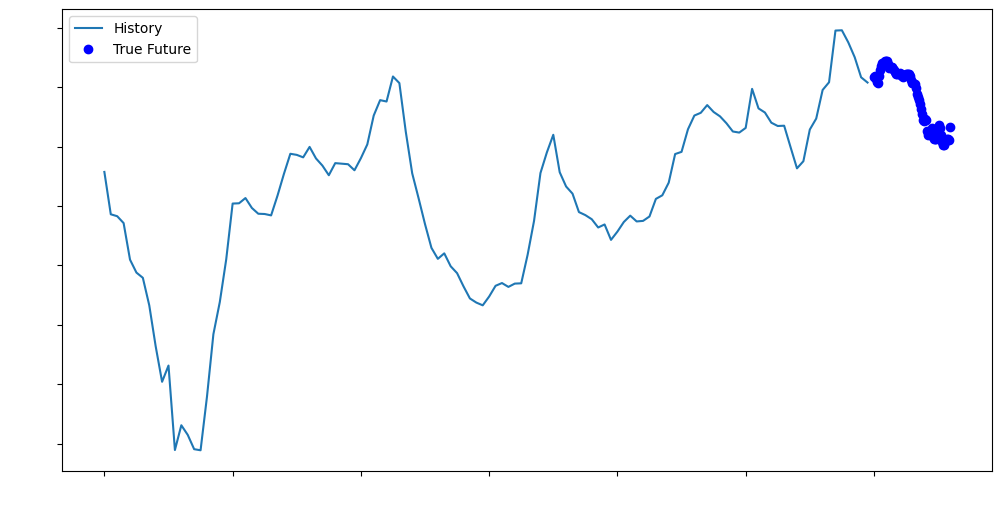

In [ ]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=10, steps_per_epoch=100, validation_data=val_data_multi, validation_steps=50)

Epoch 1/10
100/100 [==============================] - 25s 209ms/step - loss: 45.2499 - val_loss: 0.5193
Epoch 2/10
100/100 [==============================] - 20s 203ms/step - loss: 11.5314 - val_loss: 0.3056
Epoch 3/10
100/100 [==============================] - 21s 214ms/step - loss: 0.3647 - val_loss: 0.2946
Epoch 4/10
100/100 [==============================] - 23s 231ms/step - loss: 0.3373 - val_loss: 0.2824
Epoch 5/10
100/100 [==============================] - 23s 230ms/step - loss: 0.3789 - val_loss: 0.2899
Epoch 6/10
100/100 [==============================] - 20s 200ms/step - loss: 0.3358 - val_loss: 0.2598
Epoch 7/10
100/100 [==============================] - 21s 211ms/step - loss: 0.2913 - val_loss: 0.2331
Epoch 8/10
100/100 [==============================] - 20s 203ms/step - loss: 0.2547 - val_loss: 0.2203
Epoch 9/10
100/100 [==============================] - 20s 201ms/step - loss: 0.2040 - val_loss: 0.2285
Epoch 10/10
100/100 [==============================] - 22s 216ms/step -

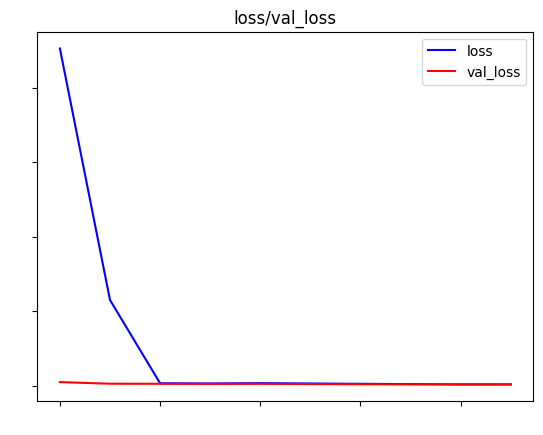

In [ ]:
plot_train_history(multi_step_history, 'loss/val_loss')

8/8 [==============================] - 1s 21ms/step


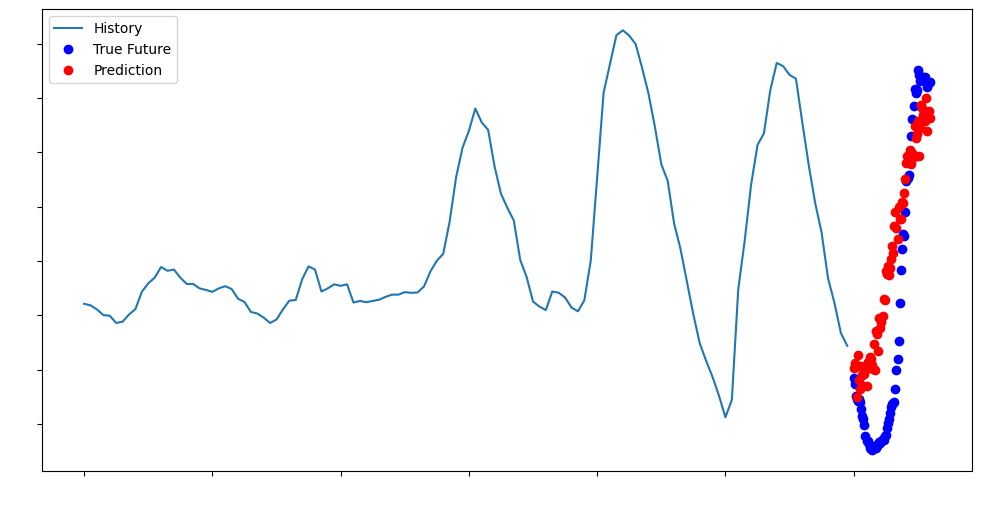

8/8 [==============================] - 0s 22ms/step


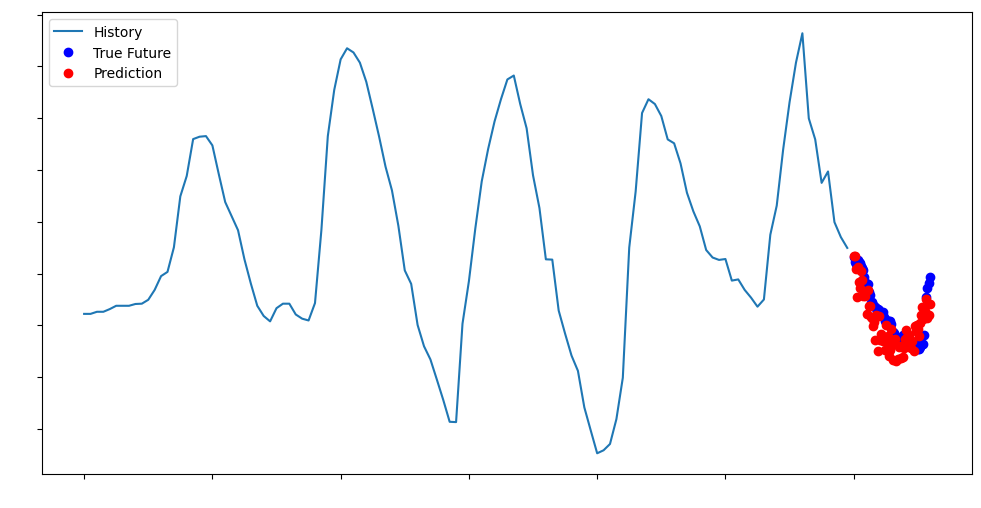

8/8 [==============================] - 0s 21ms/step


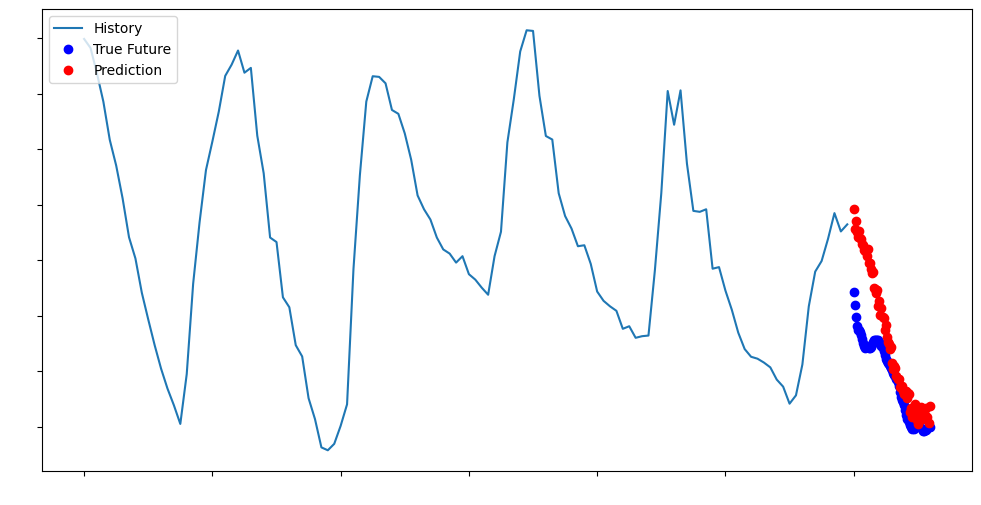

In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])